# 通用量化模型

加载一些库：

In [1]:
from torch import nn, jit
from torch.ao.quantization.qconfig import default_qconfig, get_default_qat_qconfig
from torch.ao.quantization.quantize import prepare, convert, prepare_qat
from torch.ao.quantization import disable_observer
import torch

# 设置 warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module=r'.*'
)
warnings.filterwarnings(
    action='default',
    module=r'torch.quantization'
)
# 载入自定义模块
from mod import load_mod
load_mod()

设置模型保存路径和超参数：

In [2]:
saved_model_dir = 'data/'
float_model_file = 'mobilenet_pretrained_float.pth'
scripted_float_model_file = 'mobilenet_quantization_scripted.pth'
scripted_quantized_model_file = 'mobilenet_quantization_scripted_quantized.pth'
# 超参数
learning_rate = 5e-5
num_epochs = 30
batch_size = 16
num_classes = 10

## 辅助函数

接下来，我们定义几个[帮助函数](https://github.com/pytorch/examples/blob/master/imagenet/main.py)来帮助评估模型。

In [3]:
from helper import accuracy, evaluate, print_size_of_model, load_model, train_one_epoch

## 定义数据集和数据加载器

作为最后一个主要的设置步骤，我们为训练和测试集定义了数据加载器。

In [4]:
from xinet import CV

# 为了 cifar10 匹配 ImageNet，需要将其 resize 到 224
train_iter, test_iter = CV.load_data_cifar10(batch_size=batch_size,
                                             resize=224)


Files already downloaded and verified
Files already downloaded and verified


## 微调浮点模型

配置浮点模型：

In [5]:
from torchvision.models.quantization import mobilenet_v2


def create_model(pretrained=True,
                 quantize=False,
                 num_classes=10):
    float_model = mobilenet_v2(pretrained=pretrained,
                               quantize=quantize)
    # 匹配 ``num_classes``
    float_model.classifier[1] = nn.Linear(float_model.last_channel,
                                          num_classes)
    return float_model

定义模型：

In [6]:
float_model = create_model(pretrained=True,
                           quantize=False,
                           num_classes=num_classes)

微调浮点模型：

loss 0.012, train acc 0.996, test acc 0.951
338.8 examples/sec on cuda:0


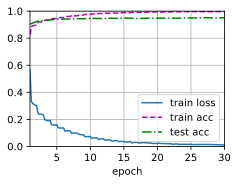

In [7]:
CV.train_fine_tuning(float_model, train_iter, test_iter,
                     learning_rate=learning_rate,
                     num_epochs=num_epochs,
                     device='cuda:0',
                     param_group=True)

保存模型：

In [8]:
torch.save(float_model.state_dict(), saved_model_dir + float_model_file)

## 配置可量化模型

In [9]:
float_model = create_model(pretrained=False,
                           quantize=False,
                           num_classes=num_classes)

float_model = load_model(float_model, saved_model_dir + float_model_file)

```{rubric} 融合模块
```

这既可以节省内存访问，使模型更快，同时也提高了数值精度。虽然这可以用于任何模型，但这在量化模型中尤其常见。

可以先查看融合前的反转残差块：

In [10]:
float_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
float_model.eval(); # 验证模式

In [12]:
# 融合模块
float_model.fuse_model()

查看融合后的反转残差块：

In [13]:
float_model.features[1].conv

Sequential(
  (0): ConvNormActivation(
    (0): ConvReLU2d(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): ReLU()
    )
    (1): Identity()
    (2): Identity()
  )
  (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
  (2): Identity()
)

最后，为了得到“基线”精度，让我们看看融合模块的非量化模型的精度：

In [14]:
num_eval_batches = 10
train_batch_size = 30
eval_batch_size = 50

criterion = nn.CrossEntropyLoss()

print("Size of baseline model")
print_size_of_model(float_model)

top1, top5 = evaluate(float_model, criterion, test_iter, neval_batches=num_eval_batches)
print('Evaluation accuracy on %d images, %2.2f'%(num_eval_batches * eval_batch_size, top1.avg))
jit.save(jit.script(float_model), saved_model_dir + scripted_float_model_file)

Size of baseline model
Size (MB): 8.923757
..........Evaluation accuracy on 500 images, 93.75


在整个模型上，在 500 幅图像的 eval 数据集上，我们得到了 $93.75%$ 的准确率。这将是我们进行比较的基准。接下来，让我们尝试不同的量化方法。

## 静态量化后训练

训练后的静态量化不仅包括将权重从 float 转换为int，就像在动态量化中一样，还包括执行额外的步骤，即首先通过网络输入一批数据，并计算不同激活的结果分布（具体来说，这是通过在记录数据的不同点插入观测者模块来实现的）。然后使用这些分布来确定如何在推断时量化不同的激活（一种简单的技术是将整个激活范围划分为 256 个级别，但我们也支持更复杂的方法）。重要的是，这个额外的步骤允许我们在运算之间传递量化的值，而不是在每个运算之间将这些值转换为浮点数（然后再转换为整数），从而显著提高了速度。

In [15]:
num_calibration_batches = 32

myModel = create_model(pretrained=False,
                       quantize=False,
                       num_classes=num_classes).to('cpu')
float_model = load_model(myModel, saved_model_dir + float_model_file)
myModel.eval()

# Fuse Conv, bn and relu
myModel.fuse_model()

# Specify quantization configuration
# Start with simple min/max range estimation and per-tensor quantization of weights
myModel.qconfig = default_qconfig
print(myModel.qconfig)
prepare(myModel, inplace=True)

# Calibrate first
print('Post Training Quantization Prepare: Inserting Observers')
print('\n Inverted Residual Block:After observer insertion \n\n',
      myModel.features[1].conv)

# Calibrate with the training set
evaluate(myModel, criterion, train_iter, neval_batches=num_calibration_batches)
print('Post Training Quantization: Calibration done')

# Convert to quantized model
convert(myModel, inplace=True)
print('Post Training Quantization: Convert done')
print('\n Inverted Residual Block: After fusion and quantization, note fused modules: \n\n',
      myModel.features[1].conv)

print("Size of model after quantization")
print_size_of_model(myModel)

top1, top5 = evaluate(myModel, criterion, test_iter,
                      neval_batches=num_eval_batches)
print('Evaluation accuracy on %d images, %2.2f' %
      (num_eval_batches * eval_batch_size, top1.avg))


QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, quant_min=0, quant_max=127){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})
Post Training Quantization Prepare: Inserting Observers

 Inverted Residual Block:After observer insertion 

 Sequential(
  (0): ConvNormActivation(
    (0): ConvReLU2d(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (1): ReLU()
      (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
    )
    (1): Identity()
    (2): Identity()
  )
  (1): Conv2d(
    32, 16, kernel_size=(1, 1), stride=(1, 1)
    (activation_post_process): MinMaxObserver(min_val=inf, max_val=-inf)
  )
  (2): Identity()
)
................................Post Training Quantization: Calibration done
Post Training Quantization: Convert done

 Inverted Residual Block: After fusion and quantization, 

/home/pc/xinet/anaconda3/envs/torchx/lib/python3.10/site-packages/torch/ao/quantization/utils.py:210: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(


..........Evaluation accuracy on 500 images, 50.62


对于这个量化模型，我们在 eval 数据集上看到了 $50.62%$ 的准确性。这是因为我们使用了一个简单的 min/max 观测器来确定量化参数。尽管如此，我们还是将模型的大小减少到了 3.6 MB 以下，几乎减少了 4 倍。

此外，我们可以通过使用不同的量化配置来显著提高精度。我们对用于量化 x86 架构的推荐配置重复同样的练习。该配置的操作如下：

- Quantizes weights on a per-channel basis
- Uses a histogram observer that collects a histogram of activations and then picks quantization parameters in an optimal manner.

In [33]:
from torch.ao.quantization.qconfig import get_default_qconfig

per_channel_quantized_model = create_model(pretrained=False,
                       quantize=False,
                       num_classes=num_classes)
per_channel_quantized_model = load_model(per_channel_quantized_model, saved_model_dir + float_model_file)
per_channel_quantized_model.eval()
per_channel_quantized_model.fuse_model()
per_channel_quantized_model.qconfig = get_default_qconfig('fbgemm')
print(per_channel_quantized_model.qconfig)

prepare(per_channel_quantized_model, inplace=True)
evaluate(per_channel_quantized_model,criterion, train_iter, num_calibration_batches)
convert(per_channel_quantized_model, inplace=True)
top1, top5 = evaluate(per_channel_quantized_model, criterion, test_iter, neval_batches=num_eval_batches)
print('Evaluation accuracy on %d images, %2.2f'%(num_eval_batches * eval_batch_size, top1.avg))
jit.save(jit.script(per_channel_quantized_model), saved_model_dir + scripted_quantized_model_file)

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})
..........................................Evaluation accuracy on 500 images, 71.25


仅仅改变这种量化配置方法，就可以将准确度提高到 $74.38%$ 以上！尽管如此，这还是比 $93.75%$ 的基线水平低了 $19%$。让我们尝试量化感知训练。

## 量化感知训练

量化感知训练（Quantization-aware training，QAT）是一种量化方法，通常可以获得最高的精度。使用 QAT，所有的权值和激活都在前向和后向训练过程中被“伪量化”：也就是说，浮点值被舍入以模拟 int8 值，但所有的计算仍然使用浮点数完成。因此，训练过程中的所有权重调整都是在“感知到”模型最终将被量化的情况下进行的；因此，在量化之后，这种方法通常比动态量化或训练后的静态量化产生更高的精度。

实际执行 QAT 的总体工作流程与之前非常相似：

- 可以使用与以前相同的模型：不需要为量化感知训练做额外的准备。
- 需要使用 `qconfig` 来指定在权重和激活之后插入何种类型的伪量化，而不是指定观测者。

像以前一样融合模块：

In [34]:
from torch.optim import SGD

qat_model = create_model(pretrained=False,
                       quantize=False,
                       num_classes=num_classes).to('cuda:0')

qat_model = load_model(qat_model, saved_model_dir + float_model_file)
qat_model.fuse_model()

optimizer = SGD(qat_model.parameters(), lr = 0.0001)
qat_model.qconfig = get_default_qat_qconfig('fbgemm')

最后，`prepare_qat` 执行“伪量化”，为量化感知训练准备模型：

In [35]:
prepare_qat(qat_model, inplace=True)
print('Inverted Residual Block: After preparation for QAT, note fake-quantization modules \n',
      qat_model.features[1].conv)

Inverted Residual Block: After preparation for QAT, note fake-quantization modules 
 Sequential(
  (0): ConvNormActivation(
    (0): ConvBnReLU2d(
      32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
        (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([], device='cuda:0'), max_val=tensor([], device='cuda:0'))
      )
      (activation_post_process): FusedMovingAvgObsFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], devi

训练具有高精确度的量化模型要求在推理时对数值进行精确的建模。因此，对于量化感知训练，我们对训练循环进行如下修改：

- 将批处理范数转换为训练结束时的运行均值和方差，以更好地匹配推理数值。
- 我们还冻结量化器参数（刻度和零点）并微调权重。

In [36]:
num_train_batches = 20
device = torch.device('cuda:0')
# QAT takes time and one needs to train over a few epochs.
# Train and check accuracy after each epoch
for nepoch in range(300):
    train_one_epoch(qat_model, criterion, optimizer, train_iter, device, num_train_batches)
    if nepoch > 3:
        # Freeze quantizer parameters
        qat_model.apply(disable_observer)
    if nepoch > 2:
        # Freeze batch norm mean and variance estimates
        qat_model.apply(nn.intrinsic.qat.freeze_bn_stats)

    # Check the accuracy after each epoch
    quantized_model = convert(qat_model.cpu().eval(), inplace=False)
    quantized_model.eval()
    top1, top5 = evaluate(quantized_model,criterion, test_iter, neval_batches=num_eval_batches)
    print('Epoch %d :Evaluation accuracy on %d images, %2.2f'%(nepoch, num_eval_batches * eval_batch_size, top1.avg))

....................Loss tensor(0.1608, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 95.000 Acc@5 100.000
..........Epoch 0 :Evaluation accuracy on 500 images, 86.25
....................Loss tensor(0.1593, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 94.375 Acc@5 100.000
..........Epoch 1 :Evaluation accuracy on 500 images, 90.62
....................Loss tensor(0.1130, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 96.250 Acc@5 100.000
..........Epoch 2 :Evaluation accuracy on 500 images, 93.75
....................Loss tensor(0.1053, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 95.625 Acc@5 100.000
..........Epoch 3 :Evaluation accuracy on 500 images, 90.00
....................Loss tensor(0.1218, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 96.250 Acc@5 100.000
..........Epoch 4 :Evaluation accuracy on 500 images, 88.75
....................Loss tensor(0.1003, device='cuda:0', grad_fn=<DivBackward0>)
Training: * Acc@1 9

量化感知训练在整个 imagenet 数据集上的准确率超过 $92.25%$，接近浮点精度 $93.75%$。

更多关于 QAT 的内容：

- QAT 是后训练量化技术的超集，允许更多的调试。例如，我们可以分析模型的准确性是否受到权重或激活量化的限制。
- 也可以在浮点上模拟量化模型的准确性，因为使用伪量化来模拟实际量化算法的数值。
- 也可以很容易地模拟训练后量化。

## 量化加速

最后，确认上面提到的一些事情：量化模型实际上执行推断更快吗？

In [22]:
import time

def run_benchmark(model_file, img_loader):
    elapsed = 0
    model = torch.jit.load(model_file)
    model.eval()
    num_batches = 5
    # Run the scripted model on a few batches of images
    for i, (images, target) in enumerate(img_loader):
        if i < num_batches:
            start = time.time()
            output = model(images)
            end = time.time()
            elapsed = elapsed + (end-start)
        else:
            break
    num_images = images.size()[0] * num_batches

    print('Elapsed time: %3.0f ms' % (elapsed/num_images*1000))
    return elapsed

run_benchmark(saved_model_dir + scripted_float_model_file, test_iter)
run_benchmark(saved_model_dir + scripted_quantized_model_file, test_iter)

Elapsed time:  15 ms
Elapsed time: 239 ms


19.094723224639893

在本地运行，常规模型的速度为 61 毫秒，量化模型的速度仅为 20 毫秒，这说明了量化模型与浮点模型相比，典型的 2-4 倍的加速。